# 4장 신경망 활용 처음부터 끝까지: 분류와 회귀

__감사말__

프랑소와 숄레의 [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff) 4장에 사용된 코드에 대한 설명을 담고 있으며 텐서플로우 2.6 버전 이상에서 작성되었습니다. 소스코드를 공개한 저자에게 감사드립니다.

__구글 코랩 설정__

'런타임 -> 런타임 유형 변경' 메뉴에서 GPU를 지정한다.
TensorFlow 버전을 확인하려면 아래 명령문을 실행한다.

In [1]:
import tensorflow as tf
tf.__version__

'2.13.1'

TensorFlow가 GPU를 사용하는지 여부를 확인하려면 아래 명령문을 실행한다.
아래와 같은 결과가 나오면 GPU가 제대로 지원됨을 의미한다.

```
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
```

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

**참고**

아래 코드에 대한 자세한 설명은
[신경망 활용 처음부터 끝까지: 분류와 회귀](https://codingalzi.github.io/dlp2/getting_started_with_neural_networks.html)를 
참고한다.

## 4.1 영화 후기: 이진 분류

**IMDB 데이터셋**

In [3]:
from tensorflow.keras.datasets import imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

훈련셋, 테스트셋의 크기 모두 25,000이다.

In [4]:
len(train_data)

25000

In [5]:
len(test_data)

25000

각 샘플은 `num_words=10000`에 의해 1~9999 사이의 정수로 이루어진 리스트이다. 
최솟값은 1, 최댓값은 9999임은 아래와 같이 확인한다.

In [6]:
min([min(sequence) for sequence in train_data])

1

In [7]:
max([max(sequence) for sequence in train_data])

9999

샘플들의 크기는 서로 다르다.

In [8]:
len(train_data[0])

218

In [9]:
len(train_data[1])

189

0번 샘플의 처음 10개 값은 다음과 같다.

In [10]:
train_data[0][:10]

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65]

각 샘플의 레이블은 0(부정) 또는 1(긍정)이다.

In [11]:
train_labels[0]

1

In [12]:
test_labels[0]

0

**_영화 후기 내용_**

후기 분류를 위해 반드시 필요한 과정은 아니지만
원한다면 후기의 내용을 확인할 수 있다.
그러기 위해 정수와 단어 사이의 관계를 담은 사전 객체 가져온다.

In [13]:
word_index = imdb.get_word_index()

`word_index`에 포함된 10개 항목을 확인하면 다음과 같다.

In [14]:
for item in list(word_index.items())[:10]:
    print(item)

('fawn', 34701)
('tsukino', 52006)
('nunnery', 52007)
('sonja', 16816)
('vani', 63951)
('woods', 1408)
('spiders', 16115)
('hanging', 2345)
('woody', 2289)
('trawling', 52008)


정수와 단어의 관계를 서로 바꾼다.

In [15]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

`reverse_word_index`에 포함된 10개 항목을 확인하면 다음과 같다.

In [16]:
for item in list(reverse_word_index.items())[:10]:
    print(item)

(34701, 'fawn')
(52006, 'tsukino')
(52007, 'nunnery')
(16816, 'sonja')
(63951, 'vani')
(1408, 'woods')
(16115, 'spiders')
(2345, 'hanging')
(2289, 'woody')
(52008, 'trawling')


첫째 리뷰 내용을 아래와 같이 확인할 수 있다.
그런데 단어 인덱스에서 3을 빼야 한다.
이유는 0, 1, 2 인덱스는 각각 여백, 문장 시작, 불분명을 의미하기 때문이다.

In [17]:
first_review = train_data[0]

decoded_review = " ".join(
    [reverse_word_index.get(i-3, "?") for i in first_review])

decoded_review

"? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you th

**데이터 전처리: 벡터화, 멀티-핫-인코딩**

멀티-핫-인코딩을 이용한 벡터화를 진행하는 함수다.

In [18]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    
    for i, seq in enumerate(sequences):    # 모든 샘플에 대한 멀티-핫-인코딩
        for j in seq:
            results[i, j] = 1.
    return results

훈련셋과 테스트셋를 벡터화한다.

In [19]:
x_train = vectorize_sequences(train_data).astype("float32")
x_test = vectorize_sequences(test_data).astype("float32")

첫째 훈련 샘플의 변환 결과는 다음과 같다.
결과를 보면 원래의 첫째 훈련 샘플에 0은 포함되지 않았지만 1과 2는 사용되었음을 알 수 있다.

In [20]:
x_train[0]

array([0., 1., 1., ..., 0., 0., 0.], dtype=float32)

실제로 확인해보면 다음과 같다.

In [21]:
0 in train_data[0]

False

In [22]:
1 in train_data[0]

True

In [23]:
2 in train_data[0]

True

레이블 또한 정수 자료형에서 `float32` 자료형으로 변환해서 자료형을 일치시킨다.

In [24]:
y_train = np.asarray(train_labels).astype("float32")
y_test = np.asarray(test_labels).astype("float32")

In [25]:
y_train

array([1., 0., 0., ..., 0., 1., 0.], dtype=float32)

In [26]:
y_test

array([0., 1., 1., ..., 0., 0., 0.], dtype=float32)

**모델 구성**

In [27]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

**모델 컴파일**

In [28]:
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

**모델 훈련**

In [29]:
# 검증 세트
x_val = x_train[:10000]
y_val = y_train[:10000]

# 훈련셋
partial_x_train = x_train[10000:]
partial_y_train = y_train[10000:]

In [30]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
30/30 [==============================] - 4s 32ms/step - loss: 0.5447 - accuracy: 0.7779 - val_loss: 0.4275 - val_accuracy: 0.8429
Epoch 2/20
30/30 [==============================] - 0s 14ms/step - loss: 0.3408 - accuracy: 0.8899 - val_loss: 0.3439 - val_accuracy: 0.8629
Epoch 3/20
30/30 [==============================] - 0s 12ms/step - loss: 0.2542 - accuracy: 0.9168 - val_loss: 0.2901 - val_accuracy: 0.8883
Epoch 4/20
30/30 [==============================] - 0s 11ms/step - loss: 0.2051 - accuracy: 0.9319 - val_loss: 0.2940 - val_accuracy: 0.8804
Epoch 5/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1711 - accuracy: 0.9445 - val_loss: 0.2754 - val_accuracy: 0.8887
Epoch 6/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1480 - accuracy: 0.9515 - val_loss: 0.2811 - val_accuracy: 0.8868
Epoch 7/20
30/30 [==============================] - 0s 11ms/step - loss: 0.1255 - accuracy: 0.9623 - val_loss: 0.3457 - val_accuracy: 0.8663
Epoch 8/20
30

**`History` 객체 활용**

`history` 속성: 평가지표를 사전 자료형으로 저장

In [31]:
history_dict = history.history

history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

*손실값의 변화*

In [32]:
import matplotlib.pyplot as plt

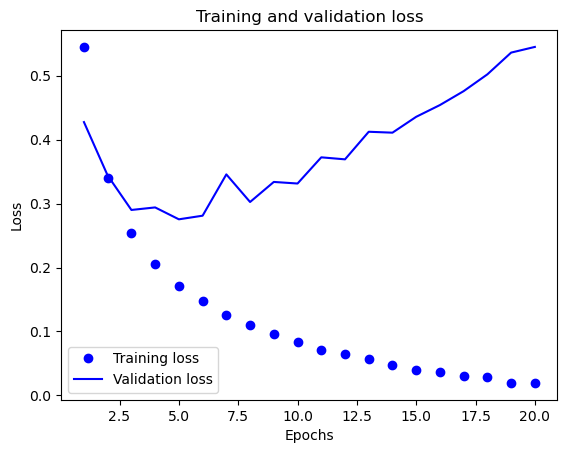

In [33]:
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")

plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

*정확도의 변화*

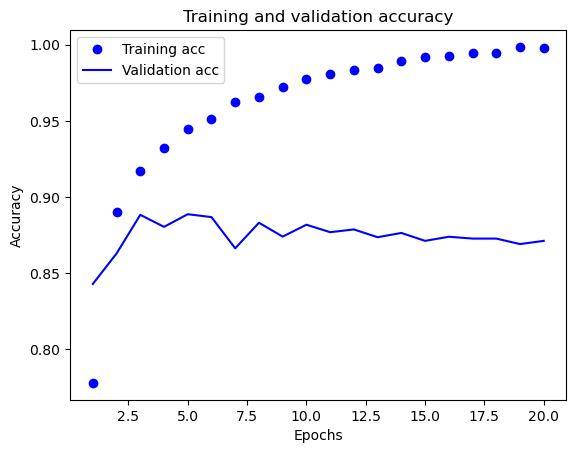

In [34]:
plt.clf()    # 이전 이미지 삭제

acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]

plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")

plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

**모델 재훈련**

In [35]:
model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.fit(x_train, y_train, epochs=4, batch_size=512)

Epoch 1/4
49/49 [==============================] - 1s 7ms/step - loss: 0.4790 - accuracy: 0.8071
Epoch 2/4
49/49 [==============================] - 0s 7ms/step - loss: 0.2853 - accuracy: 0.9005
Epoch 3/4
49/49 [==============================] - 0s 6ms/step - loss: 0.2210 - accuracy: 0.9216
Epoch 4/4
49/49 [==============================] - 0s 6ms/step - loss: 0.1877 - accuracy: 0.9332


테스트셋에 대한 성능은 아래와 같이 88% 정도의 정확도를 보인다.

In [36]:
results = model.evaluate(x_test, y_test)
results

782/782 [==============================] - 2s 2ms/step - loss: 0.2858 - accuracy: 0.8856


[0.2858474552631378, 0.885640025138855]

**모델 활용**

훈련된 모델을 활용하려면 `predict()` 메서드를 이용한다.

In [37]:
model.predict(x_test)

782/782 [==============================] - 1s 1ms/step


array([[0.17419943],
       [0.9988391 ],
       [0.69972473],
       ...,
       [0.0956466 ],
       [0.06541043],
       [0.45783457]], dtype=float32)

아래처럼 데이터셋이 클 경우 배치 단위로 묶어서 예측할 수도 있다.

In [38]:
model.predict(x_test, batch_size=512)

49/49 [==============================] - 0s 5ms/step


array([[0.17419943],
       [0.9988391 ],
       [0.69972473],
       ...,
       [0.09563317],
       [0.06540769],
       [0.4578097 ]], dtype=float32)

## 4.2 뉴스 기사: 다중 클래스 분류

**로이터 데이터셋**

In [39]:
from tensorflow.keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

훈련셋 크기

In [40]:
len(train_data)

8982

테스트셋 크기

In [41]:
len(test_data)

2246

주제별 기사 수가 다르다.
훈련셋의 타깃에 사용된 값들의 빈도수를 확인하면 다음과 같다.

In [42]:
from collections import Counter

target_counter = Counter(train_labels)
target_counter

Counter({3: 3159,
         4: 1949,
         19: 549,
         16: 444,
         1: 432,
         11: 390,
         20: 269,
         13: 172,
         8: 139,
         10: 124,
         9: 101,
         21: 100,
         25: 92,
         2: 74,
         18: 66,
         24: 62,
         0: 55,
         34: 50,
         12: 49,
         36: 49,
         28: 48,
         6: 48,
         30: 45,
         23: 41,
         31: 39,
         17: 39,
         40: 36,
         32: 32,
         41: 30,
         14: 26,
         26: 24,
         39: 24,
         43: 21,
         15: 20,
         38: 19,
         37: 19,
         29: 19,
         45: 18,
         5: 17,
         7: 16,
         27: 15,
         22: 15,
         42: 13,
         44: 12,
         33: 11,
         35: 10})

가장 많이 언급된 주제는 총 3159번,
자장 적게 언급딘 주제는 총 10번 기사로 작성되었다.

In [43]:
print(f"최대 기사 수: {max(target_counter.values())}")
print(f"최소 기사 수: {min(target_counter.values())}")

최대 기사 수: 3159
최소 기사 수: 10


각 샘플은 정수들의 리스트이다.

In [44]:
train_data[10]

[1,
 245,
 273,
 207,
 156,
 53,
 74,
 160,
 26,
 14,
 46,
 296,
 26,
 39,
 74,
 2979,
 3554,
 14,
 46,
 4689,
 4329,
 86,
 61,
 3499,
 4795,
 14,
 61,
 451,
 4329,
 17,
 12]

각 샘플 리스트의 길이가 일반적으로 다르다.

In [45]:
len(train_data[10])

31

In [46]:
len(train_data[11])

59

각 샘플에 대한 레이블은 0부터 45까지의 정수로 표현된다.
예를 들어, 10번 기사의 주제는 3이다. 

In [47]:
train_labels[10]

3

실제로 10번 기사 내용을 확인해보면 'earn'과 관련되어 있어 보인다.
데이터를 해독(decoding)하는 방법은 IMDB 데이터셋의 경우와 동일하다.

In [48]:
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

10번 기사 내용은 다음과 같다.

In [49]:
decoded_newswire = " ".join([reverse_word_index.get(i - 3, "?") for i in train_data[10]])

decoded_newswire

'? period ended december 31 shr profit 11 cts vs loss 24 cts net profit 224 271 vs loss 511 349 revs 7 258 688 vs 7 200 349 reuter 3'

**데이터 전처리**

IMDB의 경우와 동일하게 길이가 10,000인 벡터로 모든 샘플을 변환한다.

In [50]:
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

훈련셋의 레이블과 테스트셋의 레이블은 원-핫 인코딩한다.
케라스의 `to_categorical()` 함수가 원-핫-인코딩을 지원한다.

In [51]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(train_labels)
y_test = to_categorical(test_labels)

In [52]:
y_train[0]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

**모델 구성**

In [53]:
model = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(46, activation="softmax")
])

**모델 컴파일**

In [54]:
model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

**모델 훈련**

처음 1,000개의 샘플을 검증 세트 용도로 사용한다.

In [55]:
# 검증 세트
x_val = x_train[:1000]
y_val = y_train[:1000]

# 훈련셋
partial_x_train = x_train[1000:]
partial_y_train = y_train[1000:]

훈련 방식은 이전과 동일하다.

In [56]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
16/16 [==============================] - 1s 17ms/step - loss: 2.6277 - accuracy: 0.4870 - val_loss: 1.7954 - val_accuracy: 0.6270
Epoch 2/20
16/16 [==============================] - 0s 10ms/step - loss: 1.5389 - accuracy: 0.6749 - val_loss: 1.3821 - val_accuracy: 0.7020
Epoch 3/20
16/16 [==============================] - 0s 10ms/step - loss: 1.1902 - accuracy: 0.7434 - val_loss: 1.1936 - val_accuracy: 0.7350
Epoch 4/20
16/16 [==============================] - 0s 9ms/step - loss: 0.9684 - accuracy: 0.7924 - val_loss: 1.0752 - val_accuracy: 0.7630
Epoch 5/20
16/16 [==============================] - 0s 9ms/step - loss: 0.7978 - accuracy: 0.8252 - val_loss: 1.0049 - val_accuracy: 0.7780
Epoch 6/20
16/16 [==============================] - 0s 9ms/step - loss: 0.6653 - accuracy: 0.8562 - val_loss: 0.9592 - val_accuracy: 0.7920
Epoch 7/20
16/16 [==============================] - 0s 10ms/step - loss: 0.5557 - accuracy: 0.8804 - val_loss: 0.9047 - val_accuracy: 0.8120
Epoch 8/20
16/16

*손실값의 변화*

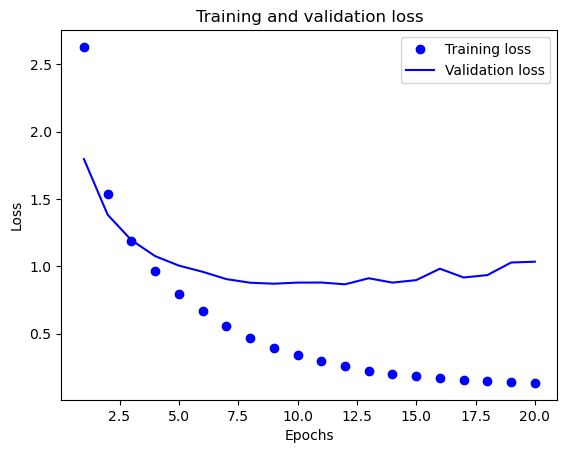

In [57]:
loss = history.history["loss"]

val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

*정확도의 변화*

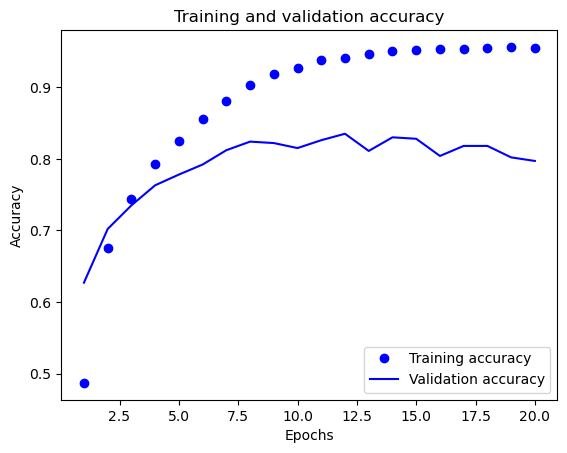

In [58]:
plt.clf()
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

**모델 재훈련**

에포크를 9번만 실행.

In [59]:
model = keras.Sequential([
  layers.Dense(64, activation="relu"),
  layers.Dense(64, activation="relu"),
  layers.Dense(46, activation="softmax")
])

model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

model.fit(x_train,
          y_train,
          epochs=9,
          batch_size=512)

Epoch 1/9
18/18 [==============================] - 1s 8ms/step - loss: 2.6014 - accuracy: 0.5210
Epoch 2/9
18/18 [==============================] - 0s 8ms/step - loss: 1.4755 - accuracy: 0.6746
Epoch 3/9
18/18 [==============================] - 0s 7ms/step - loss: 1.1359 - accuracy: 0.7455
Epoch 4/9
18/18 [==============================] - 0s 7ms/step - loss: 0.9221 - accuracy: 0.7978
Epoch 5/9
18/18 [==============================] - 0s 7ms/step - loss: 0.7558 - accuracy: 0.8349
Epoch 6/9
18/18 [==============================] - 0s 8ms/step - loss: 0.6262 - accuracy: 0.8615
Epoch 7/9
18/18 [==============================] - 0s 8ms/step - loss: 0.5196 - accuracy: 0.8873
Epoch 8/9
18/18 [==============================] - 0s 8ms/step - loss: 0.4366 - accuracy: 0.9054
Epoch 9/9
18/18 [==============================] - 0s 7ms/step - loss: 0.3733 - accuracy: 0.9194


훈련된 모델을 이용한 테스트셋에 대한 예측의 정확도는 80% 정도이다.

In [60]:
results = model.evaluate(x_test, y_test)

results

71/71 [==============================] - 0s 3ms/step - loss: 0.9070 - accuracy: 0.7863


[0.9069512486457825, 0.7862867116928101]

80%의 정확도가 얼마나 좋은지/나쁜지를 판단하려면 무작위로 찍을 때의 정확도를 계산해봐야 한다.
아래 코드가 이를 실천하며, 20% 정도의 정확도가 나온다.
따라서 80% 정도의 정확도는 상당히 좋은 편이다.

In [61]:
import copy

# 원 데이터를 건드리지 않기 위해 사본 사용
test_labels_copy = copy.copy(test_labels)

# 무작위로 섞은 후 원 데이터의 순서와 비교
np.random.shuffle(test_labels_copy)
hits_array = test_labels == test_labels_copy

# 1 또는 0으로만 이루어졌기에 평균값을 계산하면 무작위 선택의 정확도를 계산함
hits_array.mean()

0.19991095280498664

**모델 활용**

훈련된 모델을 테스트셋에 적용한다.

In [62]:
predictions = model.predict(x_test)

71/71 [==============================] - 0s 1ms/step


예측값의 모두 길이가 46인 1차원 어레이다.

In [63]:
predictions[0].shape

(46,)

예측값은 46개 클래스에 들어갈 확률들로 이루어지며 합은 1이다.

In [64]:
np.sum(predictions[0])

0.9999998

가장 큰 확률값을 가진 인덱스가 모델이 예측하는 클래스가 된다.
예를 들어 테스트셋의 0번 샘플(로이터 기사)은 3번 레이블을 갖는다고 예측된다.

In [65]:
np.argmax(predictions[0])

3

**정보 병목**

은닉층에 사용되는 유닛은 마지막 층의 유닛보다 많아야 한다.
그렇지 않으면 정보전달 과정에 병목현상(bottleneck)이 발생할 수 있다.
아래 코드의 둘째 은닉층은 4 개의 유닛만을 사용하는데 
훈련된 모델의 성능이 많이 저하된다.

In [66]:
model = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(4, activation="relu"),
    layers.Dense(46, activation="softmax")
])

model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=128,
          validation_data=(x_val, y_val))

Epoch 1/20
63/63 [==============================] - 1s 7ms/step - loss: 2.8341 - accuracy: 0.3732 - val_loss: 2.0915 - val_accuracy: 0.5620
Epoch 2/20
63/63 [==============================] - 0s 5ms/step - loss: 1.8066 - accuracy: 0.5931 - val_loss: 1.6509 - val_accuracy: 0.5980
Epoch 3/20
63/63 [==============================] - 0s 5ms/step - loss: 1.5128 - accuracy: 0.6141 - val_loss: 1.5151 - val_accuracy: 0.6140
Epoch 4/20
63/63 [==============================] - 0s 6ms/step - loss: 1.3335 - accuracy: 0.6361 - val_loss: 1.4207 - val_accuracy: 0.6190
Epoch 5/20
63/63 [==============================] - 0s 5ms/step - loss: 1.1796 - accuracy: 0.6684 - val_loss: 1.3406 - val_accuracy: 0.6680
Epoch 6/20
63/63 [==============================] - 0s 5ms/step - loss: 1.0569 - accuracy: 0.7112 - val_loss: 1.3068 - val_accuracy: 0.6630
Epoch 7/20
63/63 [==============================] - 0s 5ms/step - loss: 0.9615 - accuracy: 0.7310 - val_loss: 1.2752 - val_accuracy: 0.6860
Epoch 8/20
63/63 [==

테스트셋에 대한 정확도가 80% 정도에서 65% 정도로 낮아진다.

In [67]:
model.evaluate(x_test, y_test)

71/71 [==============================] - 0s 4ms/step - loss: 1.7735 - accuracy: 0.6830


[1.7735275030136108, 0.6829919815063477]

## 4.3 주택가격 예측: 회귀

**보스턴 주택가격 데이터셋**

In [68]:
from tensorflow.keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [69]:
train_data.shape

(404, 13)

In [70]:
test_data.shape

(102, 13)

훈련셋 샘플의 타깃은 아래처럼 범위가 지정되지 않은 부동소수점 값이다. 

In [71]:
train_targets[:10]

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4])

**데이터 전처리**

특성에 따라 사용되는 값들의 크기가 다르다. 
어떤 특성은 0과 1사이, 다른 특성은 한 자리리부터 세 자리의 수를 갖기도 한다.

In [72]:
import pandas as pd

pd.DataFrame(train_data).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12
count,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000
mean,3.745111,11.480198,11.104431,0.061881,0.557356,6.267082,69.010644,3.740271,9.440594,405.898515,18.475990,354.783168,12.740817
std,9.240734,23.767711,6.811308,0.241238,0.117293,0.709788,27.940665,2.030215,8.698360,166.374543,2.200382,94.111148,7.254545
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,188.000000,12.600000,0.320000,1.730000
25%,0.081437,0.000000,5.130000,0.000000,0.453000,5.874750,45.475000,2.077100,4.000000,279.000000,17.225000,374.672500,6.890000
50%,0.268880,0.000000,9.690000,0.000000,0.538000,6.198500,78.500000,3.142300,5.000000,330.000000,19.100000,391.250000,11.395000
75%,3.674808,12.500000,18.100000,0.000000,0.631000,6.609000,94.100000,5.118000,24.000000,666.000000,20.200000,396.157500,17.092500
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.725000,100.000000,10.710300,24.000000,711.000000,22.000000,396.900000,37.970000


*데이터 표준화*

In [73]:
# 훈련셋의 평균값
mean = train_data.mean(axis=0)

# 훈련셋 표준화
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

# 테스트셋 표준화: 훈련셋의 평균값과 표준편차 활용
test_data -= mean
test_data /= std

**모델 구성**

동일한 모델의 반복된 지정을 위해 함수로 정의한다.

In [74]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(1)
    ])
    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
    return model

**모델 훈련**

*예제: 3-겹 교차검증*

In [75]:
k = 3
num_val_samples = len(train_data) // k

num_epochs = 500
all_mae_histories = []   # 모든 에포크에 대한 평균절대오차 저장

for i in range(k):       # 교차 검증
    
    print(f"{i+1}번 째 폴드(fold) 훈련 시작")

    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    
    model = build_model()    # 유닛 수: 64
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=16, verbose=0)
    
    mae_history = history.history["val_mae"]
    all_mae_histories.append(mae_history)

1번 째 폴드(fold) 훈련 시작
2번 째 폴드(fold) 훈련 시작
3번 째 폴드(fold) 훈련 시작


에포크별 MAE 평균값 그래프 그리기

In [76]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

에포크별 평균절대오차의 평균값의 변화를 그래프로 그리면 다음과 같다.

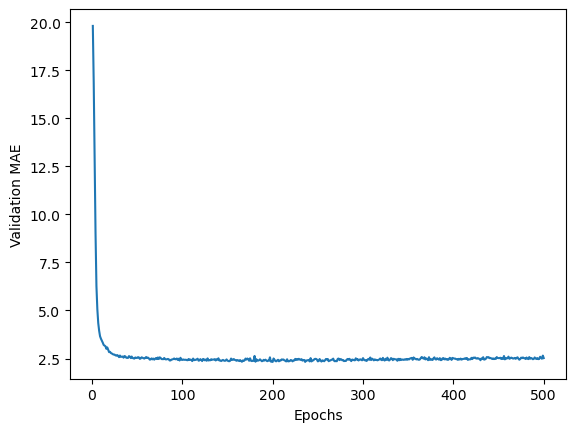

In [77]:
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)

plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

첫 10개의 에포크의 성능이 매우 나쁘기에 그 부분을 제외하고 그래프를 그리면 보다 정확하게 
변환 과정을 파악할 수 있다.

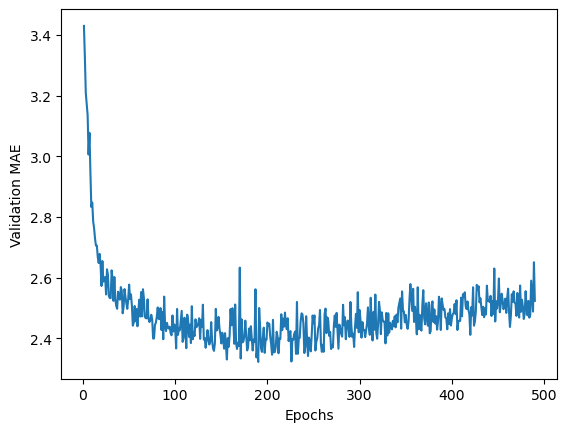

In [78]:
truncated_mae_history = average_mae_history[10:]

plt.plot(range(1, len(truncated_mae_history) + 1), truncated_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

**모델 재훈련**

210번 째 에포크를 전후로 과대적합 발생하기에
210번의 에포크만 사용해서 모델을 재훈련시킨다.

In [79]:
model = build_model()
model.fit(train_data, train_targets,
          epochs=210, batch_size=16, verbose=0)

재훈련된 모델의 테스트셋에 대한 성능을 평가하면 
주택가격 예측에 있어서 평균적으로 2,500달러 정도의 차이를 갖는다.

In [80]:
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
test_mae_score

4/4 [==============================] - 0s 3ms/step - loss: 10.3105 - mae: 2.3021


2.3020875453948975

**모델 활용**

In [81]:
predictions = model.predict(test_data)
predictions[0]

4/4 [==============================] - 0s 2ms/step


array([8.1920805], dtype=float32)

In [82]:
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
test_mae_score

4/4 [==============================] - 0s 2ms/step - loss: 10.3105 - mae: 2.3021


2.3020875453948975